In [1]:
import gwsurrogate
import numpy as np
import matplotlib.pyplot as plt
import bilby
from gwpy.timeseries import TimeSeries

lal.G_SI != G
lal.MSUN_SI != Msun
setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


In [2]:
sur=gwsurrogate.LoadSurrogate('NRSur7dq4')

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.t = h5file['t_ds'].value
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:272: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_coefs'%(key)].value,
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:273: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'bfOrders': group['%s_bfOrders'%(key)].value
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_%d_coefs'%(key, i)].value,
/Users/zohaggard/anaconda2/envs/igw

Loaded NRSur7dq4 model


In [3]:
def sigmoid(x, x0, L, k):
    
    """ generate a sigmoid to be mult. to damped sinusoid.
        x is time, x0 is the midpoint of the sigmoid, L is the amplitude, and k is the growth 
    """
    
    sig = []
    
    for item in x:
        value=L/(1+np.exp(-k*(item-x0)))
        sig.append(value)
    return sig

In [4]:
def create_bru_values(m_odd, em, M, a, n_ref):
    
    """ 
    m_odd is odd integer, g_s is string coupling (GR == 1), em is 2,
    M is total mass, a is dimensionless spin, and amplitude_qnm is 
    the amplitude of the mode of interest 
    
    returns amplitude (quantum), omega_real, tau, and tp
    
    """
    
    g_s = 1/n_ref
    c = 3e8
    G = 6.67e-11
    Msun = 1.989e30
    
    conversion_w = (c**3)/(G * M * Msun)
    R_con = (2 * G * M * Msun) / (c**2)
    
    r_s = (R_con + np.sqrt((R_con**2) - 4*(a**2)))/2 #units m
    omega_real = (m_odd * np.pi /(2 * r_s * n_ref)) * c   #units 1/m --> 1/s
    omega_im = - (1/r_s) * (1/(n_ref**2)) * c
    
    tau = 1/omega_im
    tp = 1/omega_real 
    
    print("Quantum freq is {}".format(omega_real/(2*np.pi)))
    print("Quantum tau is {}".format(tau))
    print("t_s is {}".format(tp))
    
    return {'omega_real_Q': omega_real, 'omega_img_Q': omega_im,
            'tau_Q': tau, 'tp_Q': tp, 'freq_Q': (omega_real/(2*np.pi))}

In [5]:
def damped_sine_keys(time, amplitude, tau, tp, freq, phase):
    
    """
    returns damped complex sine as h (type=array) 
    assumes that tau is negative number
    starts a time tp: anytime before is 0

    """
    
    
    h = np.zeros(len(time), dtype=np.complex128)
    tidx = time >= tp
    
    damp_arg = -(time[tidx])/tau
    sin_arg = (2 * np.pi * freq * (time[tidx])) - phase
    h[tidx] = amplitude*np.exp(damp_arg) * np.exp((1j*sin_arg)) 
    sig = sigmoid(x=time, x0=(tp*1.5), L=amplitude, k=4096)
     
    return h*sig/amplitude

In [6]:
def damped_sine(time, amplitude, tau, tp, omega_real, phase):
    
    """
    returns damped complex sine as h (type=array) 
    assumes that tau is negative number
    starts a time tp: anytime before is 0

    """
    
    
    h = np.zeros(len(time), dtype=np.complex128)
    tidx = time >= tp
    
    damp_arg = (time[tidx])/tau
    sin_arg = (omega_real * (time[tidx])) - phase
    h[tidx] = amplitude*np.exp(damp_arg) * np.exp((1j*sin_arg)) 
    
    return h

In [7]:
def Quantummodes_keys(time, q, M, dist_mpc, inclination, tau, freq, tp, amplitude, phase):
    
    """ 
    model that has NR SUR (for given parameters) and associated quantum mode 
    chiA and chiB take [x,y,x] as input
    assumes dt = 1/4096
    highest l index is ellMax, assumed to be 4
    f_ref=30, and f_low=0
    
    note: NRSUR peak of waveform packet is at t=0
    
          spin=0 for now (need to change em otherwise)
    
    """
    
    #generate NRSUR

    f_ref = 30     
    f_low = 0   
    ellMax = 4  
    chiA=[0,0,0]
    chiB=[0,0,0]
    
    t, h, dyn = sur(q, chiA, chiB, dt=1/4096, f_low=f_low,
                    ellMax=ellMax, M=M, dist_mpc=dist_mpc, units='mks',
                    inclination=inclination, f_ref=f_ref)
    #h_new
    
    
    bru_sin = damped_sine_keys(time=time, amplitude=amplitude, tau=tau, tp=tp, freq=freq, 
                          phase=phase)
    
    dif = len(bru_sin)-len(h)
    sig = sigmoid(x=time, x0=tp*1.5, L=amplitude, k=4096)
    h_new = np.pad(h, (0, dif), 'constant')
    
    h_total=h_new+bru_sin
    
    return {'plus': h_total.real*sig/amplitude, 'cross': h_total.imag*sig/amplitude}
    

In [32]:
def Quantummodes(time, q, M, dist_mpc, inclination, n_ref, amplitude, phase):
    
    """ 
    model that has NR SUR (for given parameters) and associated quantum mode 
    chiA and chiB take [x,y,x] as input
    assumes dt = 1/4096
    highest l index is ellMax, assumed to be 4
    f_ref=30, and f_low=0
    
    note: NRSUR peak of waveform packet is at t=0
    
          spin=0 for now (need to change em otherwise)
    
    """
    
    #generate NRSUR

    f_ref = 30     
    f_low = 0   
    ellMax = 4  
    
    t, h, dyn = sur(q, [0,0,0], [0,0,0], dt=1/4096, f_low=f_low,
                    ellMax=ellMax, M=M, dist_mpc=dist_mpc, units='mks',
                    inclination=inclination, f_ref=f_ref)
    #h_new
    
    bru_values = create_bru_values(m_odd=1, em=0, M=M, a=0, n_ref=n_ref)
    
    bru_sin = damped_sine(time=time, amplitude=amplitude, 
                       tau=bru_values['tau_Q'], tp=bru_values['tp_Q'], 
                       omega_real=bru_values['omega_real_Q'], phase=phase)
    print(bru_values['tp_Q'])
    sig = sigmoid(x=time, x0=bru_values['tp_Q']*1.5, L=amplitude, k=4096)
    dif = len(bru_sin)-len(h)
    h_new = np.pad(h, (0, dif), 'constant')
    h_total = h_new+(bru_sin*sig/amplitude)
    
    plt.plot(time, h_new.real, label='NRsur')
    plt.plot(time, bru_sin.real, label='unmodified Quantum')
    plt.plot(time, (bru_sin*sig)/amplitude, label='sig mult')
    plt.plot(time, h_total.real, label='total')
    plt.legend()
    plt.xlim(-0.01,0.1)
    
    return {'plus': h_total.real, 'cross': h_total.imag}
    

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


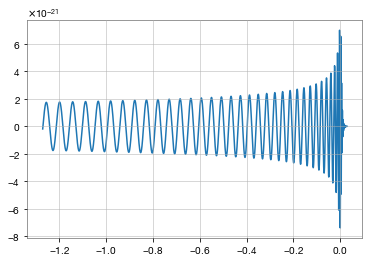

In [33]:
q = 1
chiA = [0,0,0]
chiB = [0,0,0]
M = 60
dist_mpc = 100
ellMax = 4     
inclination = 0
f_low=0
f_ref = 30
dt=1/4096

t, h, dyn = sur(q, chiA, chiB, dt=dt, f_low=f_low, ellMax=ellMax, M=M, dist_mpc=dist_mpc,
               inclination=inclination, units='mks', f_ref=f_ref)
plt.plot(t, h)

In [40]:
injection_parameters = dict(q=1, M=60, 
                            dist_mpc=100, inclination=0, n_ref=7, amplitude=5e-21, phase=0,
                            ra=0, dec=0, psi=0, geocent_time=0)

In [41]:
injection_waveform = bilby.gw.waveform_generator.WaveformGenerator(
    time_domain_source_model=Quantummodes,
    duration=2, sampling_frequency=4096,
    start_time=t[0])

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
08:02 bilby INFO    : Injected signal in H1:
08:02 bilby INFO    :   optimal SNR = 284.04
08:02 bilby INFO    :   matched filter SNR = 284.73+1.00j
08:02 bilby INFO    :   q = 1
08:02 bilby INFO    :   M = 60
08:02 bilby INFO    :   dist_mpc = 100
08:02 bilby INFO    :   inclination = 0
08:02 bilby INFO    :   n_ref = 7
08:

Quantum freq is 60.57087810328837
Quantum tau is -0.028891772000000003
t_s is 0.0026275819019908656
0.0026275819019908656


[{'plus': array([ 4.43836565e-24+0.00000000e+00j,
          2.35100028e-23-8.11255250e-24j,
          1.81778045e-23+1.03486681e-23j, ...,
         -2.59331505e-26+1.20300068e-27j,
         -2.64261820e-26-9.43625302e-28j,
         -2.44412264e-26+0.00000000e+00j]),
  'cross': array([2.91694625e-24+0.00000000e+00j,
         5.93510324e-25+2.37968797e-24j,
         2.29720021e-24-6.98592605e-25j, ...,
         2.10853182e-25+1.94364478e-27j,
         2.09847536e-25-1.72081183e-27j,
         2.13368922e-25+0.00000000e+00j])},
 {'plus': array([ 4.43836565e-24+0.00000000e+00j,
          2.35100028e-23-8.11255250e-24j,
          1.81778045e-23+1.03486681e-23j, ...,
         -2.59331505e-26+1.20300068e-27j,
         -2.64261820e-26-9.43625302e-28j,
         -2.44412264e-26+0.00000000e+00j]),
  'cross': array([2.91694625e-24+0.00000000e+00j,
         5.93510324e-25+2.37968797e-24j,
         2.29720021e-24-6.98592605e-25j, ...,
         2.10853182e-25+1.94364478e-27j,
         2.09847536e-25-1

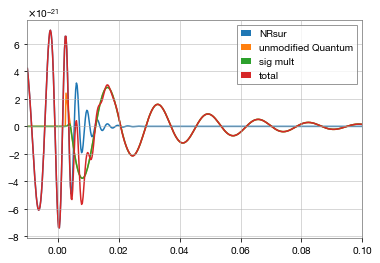

In [42]:
ifos = bilby.gw.detector.InterferometerList(['H1','L1'])
ifos.set_strain_data_from_power_spectral_densities(
    duration=2, sampling_frequency=4096)
ifos.inject_signal(waveform_generator=injection_waveform,
                  parameters=injection_parameters)

In [43]:
prior = {}
prior['amplitude'] = bilby.core.prior.DeltaFunction(5e-21, r'$h_0$')
prior['tp'] = bilby.core.prior.DeltaFunction(0.00189, r'$t_{s}$')
prior['tau'] = bilby.core.prior.LogUniform(1e-3, 1e-1, r'$\tau$', unit='$s$')
prior['freq'] = bilby.core.prior.Uniform(50, 100, r'frequency', unit='Hz')
prior['phase'] = bilby.core.prior.DeltaFunction(0)
prior['ra'] = bilby.core.prior.DeltaFunction(0)
prior['dec'] = bilby.core.prior.DeltaFunction(0)
prior['psi'] = bilby.core.prior.DeltaFunction(0)
prior['geocent_time'] = bilby.core.prior.DeltaFunction(0)
prior['q']=bilby.core.prior.DeltaFunction(1, r'$h_0$')
prior['M']=bilby.core.prior.DeltaFunction(60, r'$h_0$')
prior['dist_mpc']=bilby.core.prior.DeltaFunction(100, r'$h_0$')
prior['inclination']=bilby.core.prior.DeltaFunction(0, r'$h_0$')

In [44]:
search_waveform = bilby.gw.WaveformGenerator(
    duration=2, sampling_frequency=4096, 
    time_domain_source_model=Quantummodes_keys)

In [45]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=search_waveform)

In [ ]:
result = bilby.run_sampler(
            likelihood=likelihood, priors=prior, sampler='dynesty', npoints=500, walks=10, 
            nact=5, outdir='/Users/zohaggard/Desktop/LIGOSURF/add_quantummode/tryfull/', #change nref5,40
            label='attempt3_Mass60_nref5',
            resume=False, injection_parameters=dict(
                                                    freq=60.5,
                                                    tau=0.02))

08:03 bilby INFO    : Running for label 'attempt3_Mass60_nref5', output will be saved to '/Users/zohaggard/Desktop/LIGOSURF/add_quantummode/tryfull/'
08:03 bilby INFO    : Using LAL version Branch: None;Tag: lal-v6.22.0;Id: 38829b72bfb5f26391b9866d286dd77db7942dd1;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed
08:03 bilby INFO    : Search parameters:
08:03 bilby INFO    :   tau = LogUniform(minimum=0.001, maximum=0.1, name='$\\tau$', latex_label='$\\tau$', unit='$s$', boundary=None)
08:03 bilby INFO    :   freq = Uniform(minimum=50, maximum=100, name='frequency', latex_label='frequency', unit='Hz', boundary=None)
08:03 bilby INFO    :   amplitude = 5e-21
08:03 bilby INFO    :   tp = 0.00189
08:03 bilby INFO    :   phase = 0
08:03 bilby INFO    :   ra = 0
08:03 bilby INFO    :   dec = 0
08:03 bilby INFO    :   psi = 0
08:03 bilby INFO    :   geocent_time = 0
08:03 bilby INFO    :   q = 1
08:03 bilby INFO    :   M = 60
08:03 bilby


0it [00:00, ?it/s]

08:04 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x13d18d410>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
08:04 bilby INFO    : Checkpoint every n_check_point = 3000
08:04 bilby INFO    : Using dynesty version 1.0.1
08:05 bilby INFO    : Using the bilby-implemented rwalk sample meth


1it [01:54, 114.17s/it, bound:0 nc:1 ncall:501 eff:0.2% logz-ratio=46965.64+/-0.17 dlogz:inf>0.10]
2it [01:54, 79.99s/it, bound:0 nc:1 ncall:502 eff:0.4% logz-ratio=47399.34+/-0.17 dlogz:41370.941>0.10]
3it [01:54, 56.06s/it, bound:0 nc:1 ncall:503 eff:0.6% logz-ratio=49371.94+/-0.17 dlogz:40937.243>0.10]
4it [01:54, 39.32s/it, bound:0 nc:1 ncall:504 eff:0.8% logz-ratio=49493.14+/-0.17 dlogz:38964.639>0.10]
5it [01:55, 27.59s/it, bound:0 nc:1 ncall:505 eff:1.0% logz-ratio=49717.36+/-0.17 dlogz:38843.438>0.10]
6it [01:55, 19.38s/it, bound:0 nc:1 ncall:506 eff:1.2% logz-ratio=50517.33+/-0.17 dlogz:38619.216>0.10]
7it [01:55, 13.64s/it, bound:0 nc:1 ncall:507 eff:1.4% logz-ratio=51028.04+/-0.17 dlogz:37819.240>0.10]
8it [01:55,  9.62s/it, bound:0 nc:1 ncall:508 eff:1.6% logz-ratio=51116.64+/-0.17 dlogz:37308.530>0.10]
9it [01:56,  6.80s/it, bound:0 nc:1 ncall:509 eff:1.8% logz-ratio=51303.10+/-0.17 dlogz:37219.926>0.10]
10it [01:56,  4.83s/it, bound:0 nc:1 ncall:510 eff:2.0% logz-ratio=5

76it [02:11,  4.32it/s, bound:0 nc:1 ncall:578 eff:13.1% logz-ratio=68122.74+/-0.17 dlogz:20271.071>0.10]
77it [02:12,  4.30it/s, bound:0 nc:1 ncall:579 eff:13.3% logz-ratio=68132.79+/-0.17 dlogz:20214.818>0.10]
78it [02:12,  4.32it/s, bound:0 nc:1 ncall:580 eff:13.4% logz-ratio=68302.43+/-0.17 dlogz:20204.768>0.10]
79it [02:12,  4.03it/s, bound:0 nc:1 ncall:581 eff:13.6% logz-ratio=68458.08+/-0.17 dlogz:20035.119>0.10]
80it [02:12,  4.14it/s, bound:0 nc:1 ncall:582 eff:13.7% logz-ratio=68467.62+/-0.17 dlogz:19879.469>0.10]
81it [02:13,  4.21it/s, bound:0 nc:1 ncall:583 eff:13.9% logz-ratio=68696.82+/-0.17 dlogz:19869.932>0.10]
82it [02:13,  3.32it/s, bound:0 nc:2 ncall:585 eff:14.0% logz-ratio=68991.87+/-0.17 dlogz:19640.729>0.10]
83it [02:13,  3.57it/s, bound:0 nc:1 ncall:586 eff:14.2% logz-ratio=69063.19+/-0.17 dlogz:19345.671>0.10]
84it [02:14,  3.77it/s, bound:0 nc:1 ncall:587 eff:14.3% logz-ratio=69145.87+/-0.17 dlogz:19274.348>0.10]
85it [02:14,  3.93it/s, bound:0 nc:1 ncall:588

150it [02:33,  3.04it/s, bound:0 nc:1 ncall:673 eff:22.3% logz-ratio=76306.62+/-0.17 dlogz:12071.676>0.10]
151it [02:34,  3.33it/s, bound:0 nc:1 ncall:674 eff:22.4% logz-ratio=76431.33+/-0.17 dlogz:12030.792>0.10]
152it [02:34,  3.57it/s, bound:0 nc:1 ncall:675 eff:22.5% logz-ratio=76479.56+/-0.17 dlogz:11906.078>0.10]
153it [02:34,  3.77it/s, bound:0 nc:1 ncall:676 eff:22.6% logz-ratio=76590.42+/-0.17 dlogz:11857.847>0.10]
154it [02:34,  3.93it/s, bound:0 nc:1 ncall:677 eff:22.7% logz-ratio=76684.54+/-0.17 dlogz:11746.983>0.10]
155it [02:35,  4.04it/s, bound:0 nc:1 ncall:678 eff:22.9% logz-ratio=76760.57+/-0.17 dlogz:11652.858>0.10]
156it [02:35,  4.12it/s, bound:0 nc:1 ncall:679 eff:23.0% logz-ratio=76785.95+/-0.17 dlogz:11576.825>0.10]
157it [02:35,  4.18it/s, bound:0 nc:1 ncall:680 eff:23.1% logz-ratio=76813.03+/-0.17 dlogz:11551.447>0.10]
158it [02:35,  4.22it/s, bound:0 nc:1 ncall:681 eff:23.2% logz-ratio=76824.58+/-0.17 dlogz:11524.362>0.10]
159it [02:36,  4.23it/s, bound:0 nc:1

224it [02:54,  3.90it/s, bound:0 nc:1 ncall:761 eff:29.4% logz-ratio=81981.97+/-0.17 dlogz:6414.974>0.10]
225it [02:54,  4.00it/s, bound:0 nc:1 ncall:762 eff:29.5% logz-ratio=82025.50+/-0.17 dlogz:6355.289>0.10]
226it [02:54,  4.06it/s, bound:0 nc:1 ncall:763 eff:29.6% logz-ratio=82058.00+/-0.17 dlogz:6311.762>0.10]
227it [02:54,  4.10it/s, bound:0 nc:1 ncall:764 eff:29.7% logz-ratio=82084.03+/-0.17 dlogz:6279.258>0.10]
228it [02:55,  4.14it/s, bound:0 nc:1 ncall:765 eff:29.8% logz-ratio=82110.61+/-0.17 dlogz:6253.225>0.10]
229it [02:55,  4.19it/s, bound:0 nc:1 ncall:766 eff:29.9% logz-ratio=82121.70+/-0.17 dlogz:6226.640>0.10]
230it [02:55,  3.27it/s, bound:0 nc:2 ncall:768 eff:29.9% logz-ratio=82275.39+/-0.17 dlogz:6215.552>0.10]
231it [02:56,  3.53it/s, bound:0 nc:1 ncall:769 eff:30.0% logz-ratio=82280.09+/-0.17 dlogz:6061.855>0.10]
232it [02:56,  3.73it/s, bound:0 nc:1 ncall:770 eff:30.1% logz-ratio=82325.97+/-0.17 dlogz:6057.151>0.10]
233it [02:56,  3.89it/s, bound:0 nc:1 ncall:77

299it [03:20,  2.67it/s, bound:0 nc:2 ncall:875 eff:34.2% logz-ratio=84857.62+/-0.17 dlogz:3493.295>0.10]
300it [03:21,  2.47it/s, bound:0 nc:2 ncall:877 eff:34.2% logz-ratio=84946.69+/-0.17 dlogz:3479.490>0.10]
301it [03:21,  2.84it/s, bound:0 nc:1 ncall:878 eff:34.3% logz-ratio=84955.59+/-0.17 dlogz:3390.418>0.10]
302it [03:22,  1.92it/s, bound:0 nc:4 ncall:882 eff:34.2% logz-ratio=84983.17+/-0.17 dlogz:3381.517>0.10]
303it [03:22,  2.30it/s, bound:0 nc:1 ncall:883 eff:34.3% logz-ratio=84993.35+/-0.17 dlogz:3353.935>0.10]
304it [03:23,  2.26it/s, bound:0 nc:2 ncall:885 eff:34.4% logz-ratio=85092.87+/-0.17 dlogz:3343.749>0.10]
305it [03:24,  1.39it/s, bound:0 nc:6 ncall:891 eff:34.2% logz-ratio=85141.69+/-0.17 dlogz:3244.225>0.10]
306it [03:24,  1.56it/s, bound:0 nc:2 ncall:893 eff:34.3% logz-ratio=85146.76+/-0.17 dlogz:3195.406>0.10]
307it [03:25,  1.92it/s, bound:0 nc:1 ncall:894 eff:34.3% logz-ratio=85191.18+/-0.17 dlogz:3190.341>0.10]
308it [03:25,  2.30it/s, bound:0 nc:1 ncall:89

374it [03:55,  1.94it/s, bound:0 nc:2 ncall:1024 eff:36.5% logz-ratio=86461.10+/-0.17 dlogz:1889.920>0.10]
375it [03:55,  2.00it/s, bound:0 nc:2 ncall:1026 eff:36.5% logz-ratio=86468.13+/-0.17 dlogz:1875.858>0.10]
376it [03:56,  1.78it/s, bound:0 nc:3 ncall:1029 eff:36.5% logz-ratio=86472.86+/-0.17 dlogz:1868.826>0.10]
377it [03:56,  2.15it/s, bound:0 nc:1 ncall:1030 eff:36.6% logz-ratio=86482.89+/-0.17 dlogz:1864.098>0.10]
378it [03:57,  1.66it/s, bound:0 nc:4 ncall:1034 eff:36.6% logz-ratio=86516.16+/-0.17 dlogz:1854.061>0.10]
379it [03:57,  2.03it/s, bound:0 nc:1 ncall:1035 eff:36.6% logz-ratio=86535.16+/-0.18 dlogz:1820.795>0.10]
380it [03:58,  1.76it/s, bound:0 nc:3 ncall:1038 eff:36.6% logz-ratio=86567.70+/-0.18 dlogz:1801.785>0.10]
381it [03:58,  2.14it/s, bound:0 nc:1 ncall:1039 eff:36.7% logz-ratio=86581.97+/-0.18 dlogz:1769.252>0.10]
382it [03:58,  2.50it/s, bound:0 nc:1 ncall:1040 eff:36.7% logz-ratio=86595.25+/-0.18 dlogz:1754.977>0.10]
383it [03:59,  2.86it/s, bound:0 nc:1

448it [04:38,  1.44it/s, bound:0 nc:3 ncall:1211 eff:37.0% logz-ratio=87180.97+/-0.18 dlogz:1165.453>0.10]
449it [04:39,  1.60it/s, bound:0 nc:2 ncall:1213 eff:37.0% logz-ratio=87185.81+/-0.18 dlogz:1155.845>0.10]
450it [04:39,  1.97it/s, bound:0 nc:1 ncall:1214 eff:37.1% logz-ratio=87188.82+/-0.17 dlogz:1151.000>0.10]
451it [04:39,  2.35it/s, bound:0 nc:1 ncall:1215 eff:37.1% logz-ratio=87200.57+/-0.18 dlogz:1147.984>0.10]
452it [04:39,  2.28it/s, bound:0 nc:2 ncall:1217 eff:37.1% logz-ratio=87208.75+/-0.18 dlogz:1136.234>0.10]
453it [04:40,  2.25it/s, bound:0 nc:2 ncall:1219 eff:37.2% logz-ratio=87211.22+/-0.17 dlogz:1128.054>0.10]
454it [04:40,  2.22it/s, bound:0 nc:2 ncall:1221 eff:37.2% logz-ratio=87212.34+/-0.16 dlogz:1125.583>0.10]
455it [04:41,  2.60it/s, bound:0 nc:1 ncall:1222 eff:37.2% logz-ratio=87231.40+/-0.18 dlogz:1124.458>0.10]
456it [04:41,  2.45it/s, bound:0 nc:2 ncall:1224 eff:37.3% logz-ratio=87239.08+/-0.18 dlogz:1105.397>0.10]
457it [04:41,  2.81it/s, bound:0 nc:1

522it [05:31,  1.19it/s, bound:0 nc:4 ncall:1442 eff:36.2% logz-ratio=87593.22+/-0.17 dlogz:746.865>0.10]
523it [05:32,  1.52it/s, bound:0 nc:1 ncall:1443 eff:36.2% logz-ratio=87600.87+/-0.18 dlogz:743.445>0.10]
524it [05:32,  1.67it/s, bound:0 nc:2 ncall:1445 eff:36.3% logz-ratio=87604.49+/-0.18 dlogz:735.793>0.10]
525it [05:32,  2.05it/s, bound:0 nc:1 ncall:1446 eff:36.3% logz-ratio=87617.90+/-0.18 dlogz:732.170>0.10]
526it [05:33,  1.82it/s, bound:0 nc:3 ncall:1449 eff:36.3% logz-ratio=87627.35+/-0.18 dlogz:718.757>0.10]
527it [05:34,  1.91it/s, bound:0 nc:2 ncall:1451 eff:36.3% logz-ratio=87633.76+/-0.18 dlogz:709.308>0.10]
528it [05:34,  1.74it/s, bound:0 nc:3 ncall:1454 eff:36.3% logz-ratio=87634.87+/-0.17 dlogz:702.895>0.10]
529it [05:34,  2.12it/s, bound:0 nc:1 ncall:1455 eff:36.4% logz-ratio=87644.01+/-0.18 dlogz:701.778>0.10]
530it [05:35,  1.86it/s, bound:0 nc:3 ncall:1458 eff:36.4% logz-ratio=87649.29+/-0.18 dlogz:692.639>0.10]
531it [05:35,  2.24it/s, bound:0 nc:1 ncall:14

597it [06:18,  2.13it/s, bound:0 nc:2 ncall:1644 eff:36.3% logz-ratio=87881.79+/-0.18 dlogz:460.688>0.10]
598it [06:19,  1.87it/s, bound:0 nc:3 ncall:1647 eff:36.3% logz-ratio=87884.05+/-0.17 dlogz:455.614>0.10]
599it [06:19,  2.25it/s, bound:0 nc:1 ncall:1648 eff:36.3% logz-ratio=87886.55+/-0.17 dlogz:453.345>0.10]
600it [06:20,  2.22it/s, bound:0 nc:2 ncall:1650 eff:36.4% logz-ratio=87889.18+/-0.17 dlogz:450.847>0.10]
601it [06:20,  2.20it/s, bound:0 nc:2 ncall:1652 eff:36.4% logz-ratio=87890.34+/-0.17 dlogz:448.216>0.10]
602it [06:21,  2.19it/s, bound:0 nc:2 ncall:1654 eff:36.4% logz-ratio=87892.11+/-0.17 dlogz:447.056>0.10]
603it [06:22,  1.36it/s, bound:0 nc:6 ncall:1660 eff:36.3% logz-ratio=87893.09+/-0.16 dlogz:445.284>0.10]
604it [06:23,  1.26it/s, bound:0 nc:4 ncall:1664 eff:36.3% logz-ratio=87899.87+/-0.18 dlogz:444.298>0.10]
605it [06:23,  1.60it/s, bound:0 nc:1 ncall:1665 eff:36.3% logz-ratio=87901.55+/-0.17 dlogz:437.519>0.10]
606it [06:25,  1.13s/it, bound:0 nc:10 ncall:1

672it [07:20,  2.32it/s, bound:0 nc:1 ncall:1912 eff:35.1% logz-ratio=88030.57+/-0.18 dlogz:310.640>0.10]
673it [07:21,  2.68it/s, bound:0 nc:1 ncall:1913 eff:35.2% logz-ratio=88033.23+/-0.18 dlogz:306.682>0.10]
674it [07:21,  3.02it/s, bound:0 nc:1 ncall:1914 eff:35.2% logz-ratio=88034.24+/-0.17 dlogz:304.015>0.10]
675it [07:21,  3.29it/s, bound:0 nc:1 ncall:1915 eff:35.2% logz-ratio=88036.74+/-0.18 dlogz:303.005>0.10]
676it [07:21,  3.54it/s, bound:0 nc:1 ncall:1916 eff:35.3% logz-ratio=88037.87+/-0.17 dlogz:300.501>0.10]
677it [07:22,  2.11it/s, bound:0 nc:4 ncall:1920 eff:35.3% logz-ratio=88038.52+/-0.16 dlogz:299.375>0.10]
678it [07:22,  2.48it/s, bound:0 nc:1 ncall:1921 eff:35.3% logz-ratio=88045.11+/-0.18 dlogz:298.719>0.10]
679it [07:24,  1.59it/s, bound:0 nc:5 ncall:1926 eff:35.3% logz-ratio=88046.55+/-0.17 dlogz:292.126>0.10]
680it [07:25,  1.17it/s, bound:0 nc:6 ncall:1932 eff:35.2% logz-ratio=88047.31+/-0.16 dlogz:290.689>0.10]
681it [07:26,  1.02s/it, bound:0 nc:6 ncall:19

747it [08:32,  1.40it/s, bound:0 nc:2 ncall:2218 eff:33.7% logz-ratio=88114.94+/-0.16 dlogz:222.662>0.10]
748it [08:33,  1.27it/s, bound:0 nc:4 ncall:2222 eff:33.7% logz-ratio=88116.30+/-0.17 dlogz:222.160>0.10]
749it [08:34,  1.19it/s, bound:0 nc:4 ncall:2226 eff:33.6% logz-ratio=88117.18+/-0.16 dlogz:220.800>0.10]
750it [08:34,  1.51it/s, bound:0 nc:1 ncall:2227 eff:33.7% logz-ratio=88117.98+/-0.16 dlogz:219.919>0.10]
751it [08:35,  1.87it/s, bound:0 nc:1 ncall:2228 eff:33.7% logz-ratio=88119.00+/-0.16 dlogz:219.118>0.10]
752it [08:39,  1.60s/it, bound:0 nc:17 ncall:2245 eff:33.5% logz-ratio=88119.74+/-0.16 dlogz:218.093>0.10]
753it [08:41,  1.73s/it, bound:0 nc:8 ncall:2253 eff:33.4% logz-ratio=88120.70+/-0.16 dlogz:217.353>0.10] 
754it [08:42,  1.56s/it, bound:0 nc:5 ncall:2258 eff:33.4% logz-ratio=88121.51+/-0.16 dlogz:216.388>0.10]
755it [08:43,  1.38s/it, bound:0 nc:4 ncall:2262 eff:33.4% logz-ratio=88123.00+/-0.17 dlogz:215.582>0.10]
756it [08:46,  1.88s/it, bound:0 nc:13 ncall

821it [09:59,  1.03s/it, bound:0 nc:1 ncall:2587 eff:31.7% logz-ratio=88175.40+/-0.16 dlogz:161.875>0.10]
822it [10:00,  1.07it/s, bound:0 nc:3 ncall:2590 eff:31.7% logz-ratio=88175.71+/-0.15 dlogz:161.554>0.10]
823it [10:00,  1.38it/s, bound:0 nc:1 ncall:2591 eff:31.8% logz-ratio=88176.03+/-0.15 dlogz:161.243>0.10]
824it [10:01,  1.39it/s, bound:0 nc:3 ncall:2594 eff:31.8% logz-ratio=88176.47+/-0.15 dlogz:160.921>0.10]
825it [10:02,  1.00it/s, bound:0 nc:7 ncall:2601 eff:31.7% logz-ratio=88177.22+/-0.16 dlogz:160.481>0.10]
826it [10:03,  1.19it/s, bound:0 nc:2 ncall:2603 eff:31.7% logz-ratio=88177.89+/-0.16 dlogz:159.722>0.10]
827it [10:04,  1.01s/it, bound:0 nc:6 ncall:2609 eff:31.7% logz-ratio=88178.45+/-0.16 dlogz:159.055>0.10]
828it [10:06,  1.20s/it, bound:0 nc:7 ncall:2616 eff:31.7% logz-ratio=88178.98+/-0.16 dlogz:158.492>0.10]
829it [10:07,  1.05s/it, bound:0 nc:3 ncall:2619 eff:31.7% logz-ratio=88179.64+/-0.16 dlogz:157.955>0.10]
830it [10:09,  1.59s/it, bound:0 nc:12 ncall:2

896it [11:24,  1.13s/it, bound:0 nc:4 ncall:2947 eff:30.4% logz-ratio=88224.44+/-0.15 dlogz:112.594>0.10]
897it [11:24,  1.16it/s, bound:0 nc:1 ncall:2948 eff:30.4% logz-ratio=88224.66+/-0.15 dlogz:112.365>0.10]
898it [11:24,  1.48it/s, bound:0 nc:1 ncall:2949 eff:30.5% logz-ratio=88224.88+/-0.15 dlogz:112.138>0.10]
899it [11:25,  1.83it/s, bound:0 nc:1 ncall:2950 eff:30.5% logz-ratio=88225.20+/-0.15 dlogz:111.919>0.10]
900it [11:25,  1.68it/s, bound:0 nc:3 ncall:2953 eff:30.5% logz-ratio=88225.53+/-0.15 dlogz:111.602>0.10]
901it [11:27,  1.10it/s, bound:0 nc:7 ncall:2960 eff:30.4% logz-ratio=88225.79+/-0.15 dlogz:111.267>0.10]
902it [11:28,  1.06s/it, bound:0 nc:6 ncall:2966 eff:30.4% logz-ratio=88226.02+/-0.15 dlogz:111.005>0.10]
903it [11:31,  1.51s/it, bound:0 nc:11 ncall:2977 eff:30.3% logz-ratio=88226.27+/-0.15 dlogz:110.774>0.10]
904it [11:33,  1.55s/it, bound:0 nc:7 ncall:2984 eff:30.3% logz-ratio=88226.56+/-0.15 dlogz:110.519>0.10] 
905it [11:38,  2.64s/it, bound:0 nc:22 ncall

971it [13:14,  3.42s/it, bound:0 nc:31 ncall:3413 eff:28.5% logz-ratio=88252.14+/-0.16 dlogz:84.991>0.10]
972it [13:15,  2.89s/it, bound:0 nc:7 ncall:3420 eff:28.4% logz-ratio=88252.66+/-0.16 dlogz:84.517>0.10] 
973it [13:16,  2.23s/it, bound:0 nc:3 ncall:3423 eff:28.4% logz-ratio=88253.10+/-0.16 dlogz:83.988>0.10]
974it [13:17,  1.78s/it, bound:0 nc:3 ncall:3426 eff:28.4% logz-ratio=88253.52+/-0.16 dlogz:83.554>0.10]
975it [13:17,  1.38s/it, bound:0 nc:2 ncall:3428 eff:28.4% logz-ratio=88253.91+/-0.16 dlogz:83.131>0.10]
976it [13:18,  1.39s/it, bound:0 nc:6 ncall:3434 eff:28.4% logz-ratio=88254.21+/-0.16 dlogz:82.738>0.10]
977it [13:19,  1.12s/it, bound:0 nc:2 ncall:3436 eff:28.4% logz-ratio=88254.52+/-0.16 dlogz:82.433>0.10]
978it [13:25,  2.47s/it, bound:0 nc:24 ncall:3460 eff:28.3% logz-ratio=88254.93+/-0.16 dlogz:82.119>0.10]
979it [13:25,  1.80s/it, bound:0 nc:1 ncall:3461 eff:28.3% logz-ratio=88255.37+/-0.16 dlogz:81.705>0.10] 
980it [13:28,  2.25s/it, bound:0 nc:14 ncall:3475 e

1046it [15:25,  2.19s/it, bound:0 nc:14 ncall:3972 eff:26.3% logz-ratio=88273.73+/-0.15 dlogz:62.958>0.10]
1047it [15:26,  1.82s/it, bound:0 nc:4 ncall:3976 eff:26.3% logz-ratio=88274.04+/-0.15 dlogz:62.770>0.10] 
1048it [15:28,  1.84s/it, bound:0 nc:8 ncall:3984 eff:26.3% logz-ratio=88274.40+/-0.15 dlogz:62.458>0.10]
1049it [15:29,  1.64s/it, bound:0 nc:5 ncall:3989 eff:26.3% logz-ratio=88274.71+/-0.16 dlogz:62.098>0.10]
1050it [15:32,  1.99s/it, bound:0 nc:12 ncall:4001 eff:26.2% logz-ratio=88274.96+/-0.15 dlogz:61.789>0.10]
1051it [15:34,  1.82s/it, bound:0 nc:6 ncall:4007 eff:26.2% logz-ratio=88275.18+/-0.15 dlogz:61.532>0.10] 
1052it [15:35,  1.56s/it, bound:0 nc:4 ncall:4011 eff:26.2% logz-ratio=88275.39+/-0.15 dlogz:61.310>0.10]
1053it [15:35,  1.30s/it, bound:0 nc:3 ncall:4014 eff:26.2% logz-ratio=88275.58+/-0.15 dlogz:61.099>0.10]
1054it [15:36,  1.02it/s, bound:0 nc:1 ncall:4015 eff:26.3% logz-ratio=88275.74+/-0.15 dlogz:60.912>0.10]
1055it [15:38,  1.40s/it, bound:0 nc:10 nc

1120it [18:16,  2.59s/it, bound:0 nc:2 ncall:4693 eff:23.9% logz-ratio=88286.95+/-0.15 dlogz:49.725>0.10] 
1121it [18:19,  2.87s/it, bound:0 nc:15 ncall:4708 eff:23.8% logz-ratio=88287.05+/-0.15 dlogz:49.621>0.10]
1122it [18:20,  2.29s/it, bound:0 nc:4 ncall:4712 eff:23.8% logz-ratio=88287.14+/-0.15 dlogz:49.524>0.10] 
1123it [18:23,  2.53s/it, bound:0 nc:13 ncall:4725 eff:23.8% logz-ratio=88287.23+/-0.15 dlogz:49.431>0.10]
1124it [18:24,  1.91s/it, bound:0 nc:2 ncall:4727 eff:23.8% logz-ratio=88287.31+/-0.14 dlogz:49.343>0.10] 
1125it [18:25,  1.69s/it, bound:0 nc:5 ncall:4732 eff:23.8% logz-ratio=88287.39+/-0.14 dlogz:49.257>0.10]
1126it [18:28,  2.25s/it, bound:0 nc:15 ncall:4747 eff:23.7% logz-ratio=88287.47+/-0.14 dlogz:49.174>0.10]
1127it [18:29,  1.71s/it, bound:0 nc:2 ncall:4749 eff:23.7% logz-ratio=88287.56+/-0.14 dlogz:49.095>0.10] 
1128it [18:30,  1.70s/it, bound:0 nc:7 ncall:4756 eff:23.7% logz-ratio=88287.67+/-0.14 dlogz:49.001>0.10]
1129it [18:31,  1.26s/it, bound:0 nc:1 

1194it [25:29,  2.53s/it, bound:0 nc:5 ncall:5499 eff:21.7% logz-ratio=88297.08+/-0.15 dlogz:39.688>0.10] 
1195it [25:32,  2.82s/it, bound:0 nc:15 ncall:5514 eff:21.7% logz-ratio=88297.18+/-0.15 dlogz:39.589>0.10]
1196it [25:33,  2.04s/it, bound:0 nc:1 ncall:5515 eff:21.7% logz-ratio=88297.29+/-0.15 dlogz:39.483>0.10] 
1197it [25:36,  2.29s/it, bound:0 nc:12 ncall:5527 eff:21.7% logz-ratio=88297.40+/-0.15 dlogz:39.377>0.10]
1198it [25:38,  2.37s/it, bound:0 nc:11 ncall:5538 eff:21.6% logz-ratio=88297.51+/-0.15 dlogz:39.267>0.10]
1199it [25:40,  2.36s/it, bound:0 nc:10 ncall:5548 eff:21.6% logz-ratio=88297.64+/-0.15 dlogz:39.149>0.10]
1200it [25:42,  2.22s/it, bound:0 nc:8 ncall:5556 eff:21.6% logz-ratio=88297.76+/-0.15 dlogz:39.023>0.10] 
1201it [25:47,  2.96s/it, bound:0 nc:20 ncall:5576 eff:21.5% logz-ratio=88297.88+/-0.15 dlogz:38.896>0.10]
1202it [25:50,  2.99s/it, bound:0 nc:13 ncall:5589 eff:21.5% logz-ratio=88298.01+/-0.15 dlogz:38.772>0.10]
1203it [25:52,  2.60s/it, bound:0 nc:

1268it [28:20,  2.46s/it, bound:0 nc:22 ncall:6225 eff:20.4% logz-ratio=88305.96+/-0.15 dlogz:30.679>0.10]
1269it [28:23,  2.51s/it, bound:0 nc:11 ncall:6236 eff:20.3% logz-ratio=88306.07+/-0.15 dlogz:30.561>0.10]
1270it [28:24,  2.04s/it, bound:0 nc:4 ncall:6240 eff:20.4% logz-ratio=88306.19+/-0.15 dlogz:30.445>0.10] 
1271it [28:35,  4.80s/it, bound:0 nc:48 ncall:6288 eff:20.2% logz-ratio=88306.30+/-0.15 dlogz:30.331>0.10]
1272it [28:38,  4.35s/it, bound:0 nc:14 ncall:6302 eff:20.2% logz-ratio=88306.39+/-0.15 dlogz:30.220>0.10]
1273it [28:39,  3.40s/it, bound:0 nc:5 ncall:6307 eff:20.2% logz-ratio=88306.48+/-0.15 dlogz:30.119>0.10] 
1274it [28:41,  2.81s/it, bound:0 nc:6 ncall:6313 eff:20.2% logz-ratio=88306.58+/-0.15 dlogz:30.027>0.10]
1275it [28:41,  2.04s/it, bound:0 nc:1 ncall:6314 eff:20.2% logz-ratio=88306.68+/-0.15 dlogz:29.932>0.10]
1276it [28:45,  2.49s/it, bound:0 nc:15 ncall:6329 eff:20.2% logz-ratio=88306.78+/-0.15 dlogz:29.826>0.10]
1277it [28:50,  3.22s/it, bound:0 nc:21

08:33 bilby INFO    : Writing checkpoint file /Users/zohaggard/Desktop/LIGOSURF/add_quantummode/tryfull//attempt3_Mass60_nref5_resume.pickle




1283it [29:29,  7.93s/it, bound:0 nc:13 ncall:6515 eff:19.7% logz-ratio=88307.49+/-0.15 dlogz:29.103>0.10] 
1284it [29:29,  5.63s/it, bound:0 nc:1 ncall:6516 eff:19.7% logz-ratio=88307.58+/-0.15 dlogz:29.002>0.10] 
1285it [29:30,  4.22s/it, bound:0 nc:4 ncall:6520 eff:19.7% logz-ratio=88307.67+/-0.15 dlogz:28.910>0.10]
1286it [29:30,  3.03s/it, bound:0 nc:1 ncall:6521 eff:19.7% logz-ratio=88307.75+/-0.15 dlogz:28.821>0.10]
1287it [29:31,  2.40s/it, bound:0 nc:4 ncall:6525 eff:19.7% logz-ratio=88307.83+/-0.15 dlogz:28.735>0.10]
1288it [29:33,  2.11s/it, bound:0 nc:6 ncall:6531 eff:19.7% logz-ratio=88307.92+/-0.15 dlogz:28.651>0.10]
1289it [29:33,  1.62s/it, bound:0 nc:2 ncall:6533 eff:19.7% logz-ratio=88308.00+/-0.15 dlogz:28.565>0.10]
1290it [29:35,  1.70s/it, bound:0 nc:8 ncall:6541 eff:19.7% logz-ratio=88308.08+/-0.15 dlogz:28.480>0.10]
1291it [29:35,  1.26s/it, bound:0 nc:1 ncall:6542 eff:19.7% logz-ratio=88308.15+/-0.15 dlogz:28.401>0.10]
1292it [29:38,  1.80s/it, bound:0 nc:13 n

1357it [33:39,  1.75s/it, bound:0 nc:5 ncall:7544 eff:18.0% logz-ratio=88312.57+/-0.14 dlogz:23.841>0.10]
1358it [33:47,  3.63s/it, bound:0 nc:33 ncall:7577 eff:17.9% logz-ratio=88312.64+/-0.14 dlogz:23.771>0.10]
1359it [34:03,  7.44s/it, bound:0 nc:68 ncall:7645 eff:17.8% logz-ratio=88312.72+/-0.14 dlogz:23.698>0.10]
1360it [34:04,  5.35s/it, bound:0 nc:2 ncall:7647 eff:17.8% logz-ratio=88312.79+/-0.14 dlogz:23.622>0.10] 
1361it [34:08,  4.93s/it, bound:0 nc:16 ncall:7663 eff:17.8% logz-ratio=88312.87+/-0.14 dlogz:23.543>0.10]
1362it [34:10,  4.19s/it, bound:0 nc:10 ncall:7673 eff:17.8% logz-ratio=88312.95+/-0.14 dlogz:23.462>0.10]
1363it [34:16,  4.69s/it, bound:0 nc:24 ncall:7697 eff:17.7% logz-ratio=88313.04+/-0.15 dlogz:23.379>0.10]
1364it [34:17,  3.65s/it, bound:0 nc:5 ncall:7702 eff:17.7% logz-ratio=88313.14+/-0.15 dlogz:23.288>0.10] 
1365it [34:38,  8.77s/it, bound:0 nc:86 ncall:7788 eff:17.5% logz-ratio=88313.23+/-0.15 dlogz:23.192>0.10]
1366it [34:43,  7.61s/it, bound:0 nc:2

1431it [39:54,  7.06s/it, bound:0 nc:14 ncall:9003 eff:15.9% logz-ratio=88316.70+/-0.14 dlogz:19.544>0.10]
1432it [39:54,  5.16s/it, bound:0 nc:3 ncall:9006 eff:15.9% logz-ratio=88316.75+/-0.14 dlogz:19.498>0.10] 
1433it [40:03,  6.06s/it, bound:0 nc:33 ncall:9039 eff:15.9% logz-ratio=88316.79+/-0.14 dlogz:19.448>0.10]
1434it [40:08,  5.87s/it, bound:0 nc:22 ncall:9061 eff:15.8% logz-ratio=88316.84+/-0.14 dlogz:19.398>0.10]
1435it [40:09,  4.26s/it, bound:0 nc:2 ncall:9063 eff:15.8% logz-ratio=88316.89+/-0.14 dlogz:19.349>0.10] 
1436it [40:13,  4.19s/it, bound:0 nc:17 ncall:9080 eff:15.8% logz-ratio=88316.93+/-0.14 dlogz:19.301>0.10]
1437it [40:16,  3.99s/it, bound:0 nc:15 ncall:9095 eff:15.8% logz-ratio=88316.97+/-0.14 dlogz:19.254>0.10]
1438it [40:21,  4.42s/it, bound:0 nc:23 ncall:9118 eff:15.8% logz-ratio=88317.02+/-0.14 dlogz:19.209>0.10]
1439it [40:26,  4.47s/it, bound:0 nc:19 ncall:9137 eff:15.7% logz-ratio=88317.06+/-0.14 dlogz:19.164>0.10]
1440it [40:30,  4.34s/it, bound:0 nc:

1505it [46:56,  8.18s/it, bound:0 nc:56 ncall:10728 eff:14.0% logz-ratio=88319.36+/-0.14 dlogz:16.716>0.10]
1506it [47:00,  6.98s/it, bound:0 nc:17 ncall:10745 eff:14.0% logz-ratio=88319.39+/-0.14 dlogz:16.684>0.10]
1507it [47:01,  5.11s/it, bound:0 nc:3 ncall:10748 eff:14.0% logz-ratio=88319.43+/-0.14 dlogz:16.651>0.10] 
1508it [47:10,  6.28s/it, bound:0 nc:37 ncall:10785 eff:14.0% logz-ratio=88319.46+/-0.14 dlogz:16.618>0.10]
1509it [47:31, 10.50s/it, bound:0 nc:83 ncall:10868 eff:13.9% logz-ratio=88319.49+/-0.14 dlogz:16.584>0.10]
1510it [47:33,  8.08s/it, bound:0 nc:10 ncall:10878 eff:13.9% logz-ratio=88319.52+/-0.14 dlogz:16.550>0.10]
1511it [47:35,  6.32s/it, bound:0 nc:9 ncall:10887 eff:13.9% logz-ratio=88319.56+/-0.14 dlogz:16.514>0.10] 
1512it [47:38,  5.17s/it, bound:0 nc:10 ncall:10897 eff:13.9% logz-ratio=88319.59+/-0.14 dlogz:16.479>0.10]
1513it [47:44,  5.38s/it, bound:0 nc:24 ncall:10921 eff:13.9% logz-ratio=88319.62+/-0.14 dlogz:16.443>0.10]
1514it [47:45,  4.27s/it, bo

1578it [53:28,  2.55s/it, bound:0 nc:16 ncall:12312 eff:12.8% logz-ratio=88321.48+/-0.14 dlogz:14.451>0.10]
1579it [53:34,  3.63s/it, bound:0 nc:25 ncall:12337 eff:12.8% logz-ratio=88321.51+/-0.14 dlogz:14.420>0.10]
1580it [53:46,  6.21s/it, bound:0 nc:49 ncall:12386 eff:12.8% logz-ratio=88321.54+/-0.14 dlogz:14.387>0.10]
1581it [53:50,  5.39s/it, bound:0 nc:14 ncall:12400 eff:12.8% logz-ratio=88321.57+/-0.14 dlogz:14.355>0.10]
1582it [53:57,  5.91s/it, bound:0 nc:29 ncall:12429 eff:12.7% logz-ratio=88321.60+/-0.14 dlogz:14.323>0.10]
1583it [54:16,  9.94s/it, bound:0 nc:78 ncall:12507 eff:12.7% logz-ratio=88321.63+/-0.14 dlogz:14.292>0.10]
1584it [54:27, 10.12s/it, bound:0 nc:43 ncall:12550 eff:12.6% logz-ratio=88321.66+/-0.14 dlogz:14.261>0.10]
1585it [54:27,  7.31s/it, bound:0 nc:3 ncall:12553 eff:12.6% logz-ratio=88321.69+/-0.14 dlogz:14.230>0.10] 
1586it [54:34,  7.24s/it, bound:0 nc:29 ncall:12582 eff:12.6% logz-ratio=88321.72+/-0.14 dlogz:14.199>0.10]
1587it [54:39,  6.39s/it, bo

1651it [1:00:02,  5.44s/it, bound:0 nc:27 ncall:13900 eff:11.9% logz-ratio=88323.16+/-0.14 dlogz:12.612>0.10]
1652it [1:00:02,  3.89s/it, bound:0 nc:1 ncall:13901 eff:11.9% logz-ratio=88323.18+/-0.14 dlogz:12.591>0.10] 
1653it [1:00:14,  6.35s/it, bound:0 nc:48 ncall:13949 eff:11.9% logz-ratio=88323.20+/-0.14 dlogz:12.570>0.10]
1654it [1:00:15,  4.67s/it, bound:0 nc:3 ncall:13952 eff:11.9% logz-ratio=88323.22+/-0.14 dlogz:12.548>0.10] 
1655it [1:00:31,  8.09s/it, bound:0 nc:65 ncall:14017 eff:11.8% logz-ratio=88323.24+/-0.14 dlogz:12.526>0.10]
1656it [1:00:34,  6.77s/it, bound:0 nc:15 ncall:14032 eff:11.8% logz-ratio=88323.26+/-0.14 dlogz:12.504>0.10]
1657it [1:00:49,  9.10s/it, bound:0 nc:58 ncall:14090 eff:11.8% logz-ratio=88323.28+/-0.14 dlogz:12.483>0.10]
1658it [1:00:55,  8.30s/it, bound:0 nc:26 ncall:14116 eff:11.7% logz-ratio=88323.30+/-0.14 dlogz:12.461>0.10]
1659it [1:01:20, 13.11s/it, bound:0 nc:98 ncall:14214 eff:11.7% logz-ratio=88323.32+/-0.14 dlogz:12.440>0.10]
1660it [1:

09:10 bilby INFO    : Writing checkpoint file /Users/zohaggard/Desktop/LIGOSURF/add_quantummode/tryfull//attempt3_Mass60_nref5_resume.pickle




1709it [1:06:45,  4.69s/it, bound:0 nc:13 ncall:15517 eff:11.0% logz-ratio=88324.18+/-0.14 dlogz:11.476>0.10]
1710it [1:06:46,  3.66s/it, bound:0 nc:5 ncall:15522 eff:11.0% logz-ratio=88324.20+/-0.14 dlogz:11.458>0.10] 
1711it [1:07:09,  9.49s/it, bound:0 nc:92 ncall:15614 eff:11.0% logz-ratio=88324.22+/-0.14 dlogz:11.439>0.10]
1712it [1:07:13,  7.85s/it, bound:0 nc:16 ncall:15630 eff:11.0% logz-ratio=88324.23+/-0.14 dlogz:11.420>0.10]
1713it [1:07:21,  7.83s/it, bound:0 nc:31 ncall:15661 eff:10.9% logz-ratio=88324.25+/-0.14 dlogz:11.401>0.10]
1714it [1:07:35,  9.85s/it, bound:0 nc:58 ncall:15719 eff:10.9% logz-ratio=88324.27+/-0.14 dlogz:11.382>0.10]
1715it [1:07:36,  7.04s/it, bound:0 nc:2 ncall:15721 eff:10.9% logz-ratio=88324.28+/-0.14 dlogz:11.363>0.10] 
1716it [1:07:51,  9.30s/it, bound:0 nc:59 ncall:15780 eff:10.9% logz-ratio=88324.30+/-0.14 dlogz:11.343>0.10]
1717it [1:07:51,  6.59s/it, bound:0 nc:1 ncall:15781 eff:10.9% logz-ratio=88324.32+/-0.14 dlogz:11.324>0.10] 
1718it [

1781it [1:15:21,  5.90s/it, bound:0 nc:15 ncall:17545 eff:10.2% logz-ratio=88325.37+/-0.14 dlogz:10.139>0.10]
1782it [1:15:27,  5.87s/it, bound:0 nc:23 ncall:17568 eff:10.1% logz-ratio=88325.39+/-0.14 dlogz:10.123>0.10]
1783it [1:15:54, 12.11s/it, bound:0 nc:105 ncall:17673 eff:10.1% logz-ratio=88325.40+/-0.14 dlogz:10.106>0.10]
1784it [1:16:00, 10.35s/it, bound:0 nc:25 ncall:17698 eff:10.1% logz-ratio=88325.42+/-0.14 dlogz:10.090>0.10] 
1785it [1:16:08,  9.65s/it, bound:0 nc:32 ncall:17730 eff:10.1% logz-ratio=88325.43+/-0.14 dlogz:10.074>0.10]
1786it [1:16:21, 10.45s/it, bound:0 nc:48 ncall:17778 eff:10.0% logz-ratio=88325.44+/-0.14 dlogz:10.058>0.10]
1787it [1:16:28,  9.46s/it, bound:0 nc:28 ncall:17806 eff:10.0% logz-ratio=88325.46+/-0.14 dlogz:10.042>0.10]
1788it [1:16:30,  7.31s/it, bound:0 nc:9 ncall:17815 eff:10.0% logz-ratio=88325.47+/-0.14 dlogz:10.025>0.10] 
1789it [1:16:41,  8.44s/it, bound:0 nc:43 ncall:17858 eff:10.0% logz-ratio=88325.49+/-0.14 dlogz:10.009>0.10]
1790it [

1854it [1:21:58,  4.52s/it, bound:4 nc:14 ncall:19040 eff:9.7% logz-ratio=88326.40+/-0.14 dlogz:8.966>0.10]
1855it [1:22:02,  4.48s/it, bound:4 nc:16 ncall:19056 eff:9.7% logz-ratio=88326.41+/-0.14 dlogz:8.951>0.10]
1856it [1:22:08,  4.91s/it, bound:4 nc:22 ncall:19078 eff:9.7% logz-ratio=88326.42+/-0.14 dlogz:8.937>0.10]
1857it [1:22:13,  4.89s/it, bound:4 nc:18 ncall:19096 eff:9.7% logz-ratio=88326.44+/-0.14 dlogz:8.922>0.10]
1858it [1:22:17,  4.71s/it, bound:4 nc:16 ncall:19112 eff:9.7% logz-ratio=88326.45+/-0.14 dlogz:8.908>0.10]
1859it [1:22:23,  4.91s/it, bound:4 nc:20 ncall:19132 eff:9.7% logz-ratio=88326.46+/-0.14 dlogz:8.893>0.10]
1860it [1:22:28,  4.99s/it, bound:4 nc:19 ncall:19151 eff:9.7% logz-ratio=88326.47+/-0.14 dlogz:8.879>0.10]
1861it [1:22:31,  4.42s/it, bound:4 nc:11 ncall:19162 eff:9.7% logz-ratio=88326.49+/-0.14 dlogz:8.865>0.10]
1862it [1:22:36,  4.49s/it, bound:4 nc:17 ncall:19179 eff:9.7% logz-ratio=88326.50+/-0.14 dlogz:8.851>0.10]
1863it [1:22:41,  4.71s/it, 

1927it [1:29:28,  8.95s/it, bound:9 nc:37 ncall:20617 eff:9.3% logz-ratio=88327.24+/-0.13 dlogz:7.980>0.10]
1928it [1:29:38,  9.45s/it, bound:9 nc:38 ncall:20655 eff:9.3% logz-ratio=88327.25+/-0.13 dlogz:7.968>0.10]
1929it [1:29:45,  8.66s/it, bound:9 nc:24 ncall:20679 eff:9.3% logz-ratio=88327.26+/-0.13 dlogz:7.956>0.10]
1930it [1:29:53,  8.29s/it, bound:9 nc:26 ncall:20705 eff:9.3% logz-ratio=88327.27+/-0.13 dlogz:7.944>0.10]
1931it [1:30:02,  8.61s/it, bound:9 nc:33 ncall:20738 eff:9.3% logz-ratio=88327.28+/-0.13 dlogz:7.932>0.10]
1932it [1:30:12,  9.06s/it, bound:9 nc:36 ncall:20774 eff:9.3% logz-ratio=88327.29+/-0.13 dlogz:7.920>0.10]
1933it [1:30:23,  9.56s/it, bound:9 nc:39 ncall:20813 eff:9.3% logz-ratio=88327.30+/-0.13 dlogz:7.908>0.10]
1934it [1:30:32,  9.56s/it, bound:10 nc:35 ncall:20848 eff:9.3% logz-ratio=88327.31+/-0.13 dlogz:7.896>0.10]
1935it [1:30:38,  8.29s/it, bound:10 nc:19 ncall:20867 eff:9.3% logz-ratio=88327.32+/-0.13 dlogz:7.884>0.10]
1936it [1:30:47,  8.68s/it

2000it [1:37:57,  8.76s/it, bound:14 nc:37 ncall:22408 eff:8.9% logz-ratio=88327.90+/-0.13 dlogz:7.167>0.10]
2001it [1:38:06,  8.89s/it, bound:15 nc:32 ncall:22440 eff:8.9% logz-ratio=88327.91+/-0.13 dlogz:7.157>0.10]
2002it [1:38:13,  8.26s/it, bound:15 nc:26 ncall:22466 eff:8.9% logz-ratio=88327.92+/-0.13 dlogz:7.147>0.10]
2003it [1:38:21,  8.05s/it, bound:15 nc:26 ncall:22492 eff:8.9% logz-ratio=88327.93+/-0.13 dlogz:7.136>0.10]
2004it [1:38:29,  8.26s/it, bound:15 nc:28 ncall:22520 eff:8.9% logz-ratio=88327.94+/-0.13 dlogz:7.126>0.10]
2005it [1:38:38,  8.44s/it, bound:15 nc:31 ncall:22551 eff:8.9% logz-ratio=88327.94+/-0.13 dlogz:7.116>0.10]
2006it [1:38:46,  8.31s/it, bound:15 nc:28 ncall:22579 eff:8.9% logz-ratio=88327.95+/-0.13 dlogz:7.106>0.10]
2007it [1:38:51,  7.28s/it, bound:15 nc:18 ncall:22597 eff:8.9% logz-ratio=88327.96+/-0.13 dlogz:7.096>0.10]
2008it [1:38:58,  7.15s/it, bound:15 nc:24 ncall:22621 eff:8.9% logz-ratio=88327.97+/-0.13 dlogz:7.086>0.10]
2009it [1:39:07,  7

2073it [1:45:55,  4.58s/it, bound:20 nc:18 ncall:24213 eff:8.6% logz-ratio=88328.46+/-0.13 dlogz:6.744>0.10]
2074it [1:45:59,  4.55s/it, bound:20 nc:17 ncall:24230 eff:8.6% logz-ratio=88328.46+/-0.13 dlogz:6.735>0.10]
2075it [1:46:04,  4.80s/it, bound:20 nc:21 ncall:24251 eff:8.6% logz-ratio=88328.47+/-0.13 dlogz:6.726>0.10]
2076it [1:46:09,  4.71s/it, bound:20 nc:17 ncall:24268 eff:8.6% logz-ratio=88328.48+/-0.13 dlogz:6.718>0.10]
2077it [1:46:14,  4.82s/it, bound:20 nc:19 ncall:24287 eff:8.6% logz-ratio=88328.48+/-0.13 dlogz:6.709>0.10]
2078it [1:46:20,  5.15s/it, bound:21 nc:22 ncall:24309 eff:8.5% logz-ratio=88328.49+/-0.13 dlogz:6.701>0.10]
2079it [1:46:23,  4.59s/it, bound:21 nc:12 ncall:24321 eff:8.5% logz-ratio=88328.50+/-0.13 dlogz:6.692>0.10]
2080it [1:46:29,  4.79s/it, bound:21 nc:20 ncall:24341 eff:8.5% logz-ratio=88328.50+/-0.13 dlogz:6.683>0.10]
2081it [1:46:33,  4.80s/it, bound:21 nc:18 ncall:24359 eff:8.5% logz-ratio=88328.51+/-0.13 dlogz:6.675>0.10]
2082it [1:46:38,  4

2146it [1:51:39,  4.32s/it, bound:24 nc:14 ncall:25496 eff:8.4% logz-ratio=88328.90+/-0.13 dlogz:6.156>0.10]
2147it [1:51:44,  4.33s/it, bound:24 nc:16 ncall:25512 eff:8.4% logz-ratio=88328.91+/-0.13 dlogz:6.148>0.10]
2148it [1:51:48,  4.41s/it, bound:24 nc:17 ncall:25529 eff:8.4% logz-ratio=88328.91+/-0.13 dlogz:6.140>0.10]
2149it [1:51:52,  4.09s/it, bound:25 nc:12 ncall:25541 eff:8.4% logz-ratio=88328.92+/-0.13 dlogz:6.133>0.10]
2150it [1:51:56,  4.09s/it, bound:25 nc:15 ncall:25556 eff:8.4% logz-ratio=88328.92+/-0.13 dlogz:6.125>0.10]
2151it [1:52:03,  4.94s/it, bound:25 nc:26 ncall:25582 eff:8.4% logz-ratio=88328.93+/-0.13 dlogz:6.117>0.10]
2152it [1:52:08,  4.92s/it, bound:25 nc:18 ncall:25600 eff:8.4% logz-ratio=88328.93+/-0.13 dlogz:6.109>0.10]
2153it [1:52:11,  4.53s/it, bound:25 nc:13 ncall:25613 eff:8.4% logz-ratio=88328.94+/-0.13 dlogz:6.101>0.10]
2154it [1:52:17,  4.94s/it, bound:25 nc:22 ncall:25635 eff:8.4% logz-ratio=88328.95+/-0.13 dlogz:6.094>0.10]
2155it [1:52:21,  4

2219it [1:57:46,  7.41s/it, bound:29 nc:31 ncall:26848 eff:8.3% logz-ratio=88329.28+/-0.13 dlogz:5.629>0.10]
2220it [1:57:55,  7.91s/it, bound:29 nc:34 ncall:26882 eff:8.3% logz-ratio=88329.29+/-0.13 dlogz:5.622>0.10]
2221it [1:58:05,  8.60s/it, bound:29 nc:38 ncall:26920 eff:8.3% logz-ratio=88329.29+/-0.13 dlogz:5.615>0.10]
2222it [1:58:14,  8.72s/it, bound:29 nc:34 ncall:26954 eff:8.2% logz-ratio=88329.30+/-0.13 dlogz:5.609>0.10]
2223it [1:58:22,  8.56s/it, bound:29 nc:31 ncall:26985 eff:8.2% logz-ratio=88329.30+/-0.13 dlogz:5.602>0.10]
2224it [1:58:30,  8.34s/it, bound:29 nc:30 ncall:27015 eff:8.2% logz-ratio=88329.31+/-0.13 dlogz:5.595>0.10]
2225it [1:58:37,  7.88s/it, bound:29 nc:26 ncall:27041 eff:8.2% logz-ratio=88329.31+/-0.13 dlogz:5.588>0.10]
2226it [1:58:43,  7.29s/it, bound:29 nc:22 ncall:27063 eff:8.2% logz-ratio=88329.31+/-0.13 dlogz:5.582>0.10]
2227it [1:58:50,  7.31s/it, bound:30 nc:27 ncall:27090 eff:8.2% logz-ratio=88329.32+/-0.13 dlogz:5.575>0.10]
2228it [1:58:57,  7

10:04 bilby INFO    : Writing checkpoint file /Users/zohaggard/Desktop/LIGOSURF/add_quantummode/tryfull//attempt3_Mass60_nref5_resume.pickle




2245it [2:00:49,  6.89s/it, bound:31 nc:24 ncall:27532 eff:8.2% logz-ratio=88329.40+/-0.13 dlogz:5.458>0.10]
2246it [2:00:56,  7.02s/it, bound:31 nc:27 ncall:27559 eff:8.1% logz-ratio=88329.41+/-0.13 dlogz:5.452>0.10]
2247it [2:01:03,  6.92s/it, bound:31 nc:25 ncall:27584 eff:8.1% logz-ratio=88329.41+/-0.13 dlogz:5.445>0.10]
2248it [2:01:12,  7.48s/it, bound:31 nc:34 ncall:27618 eff:8.1% logz-ratio=88329.41+/-0.13 dlogz:5.439>0.10]
2249it [2:01:19,  7.29s/it, bound:31 nc:26 ncall:27644 eff:8.1% logz-ratio=88329.42+/-0.13 dlogz:5.433>0.10]
2250it [2:01:26,  7.26s/it, bound:31 nc:27 ncall:27671 eff:8.1% logz-ratio=88329.42+/-0.13 dlogz:5.426>0.10]
2251it [2:01:34,  7.62s/it, bound:31 nc:32 ncall:27703 eff:8.1% logz-ratio=88329.43+/-0.13 dlogz:5.420>0.10]
2252it [2:01:41,  7.28s/it, bound:32 nc:24 ncall:27727 eff:8.1% logz-ratio=88329.43+/-0.13 dlogz:5.414>0.10]
2253it [2:01:48,  7.30s/it, bound:32 nc:27 ncall:27754 eff:8.1% logz-ratio=88329.44+/-0.13 dlogz:5.407>0.10]
2254it [2:01:54, 

2318it [2:10:25,  8.71s/it, bound:38 nc:29 ncall:29682 eff:7.8% logz-ratio=88329.70+/-0.13 dlogz:5.013>0.10]
2319it [2:10:33,  8.39s/it, bound:38 nc:28 ncall:29710 eff:7.8% logz-ratio=88329.71+/-0.13 dlogz:5.007>0.10]
2320it [2:10:40,  8.08s/it, bound:38 nc:27 ncall:29737 eff:7.8% logz-ratio=88329.71+/-0.13 dlogz:5.001>0.10]
2321it [2:10:46,  7.52s/it, bound:38 nc:23 ncall:29760 eff:7.8% logz-ratio=88329.71+/-0.13 dlogz:4.995>0.10]
2322it [2:10:54,  7.43s/it, bound:38 nc:27 ncall:29787 eff:7.8% logz-ratio=88329.72+/-0.13 dlogz:4.989>0.10]
2323it [2:11:02,  7.75s/it, bound:38 nc:32 ncall:29819 eff:7.8% logz-ratio=88329.72+/-0.13 dlogz:4.984>0.10]
2324it [2:11:08,  7.20s/it, bound:38 nc:22 ncall:29841 eff:7.8% logz-ratio=88329.73+/-0.13 dlogz:4.978>0.10]
2325it [2:11:14,  6.96s/it, bound:38 nc:24 ncall:29865 eff:7.8% logz-ratio=88329.73+/-0.13 dlogz:4.972>0.10]
2326it [2:11:24,  7.71s/it, bound:38 nc:35 ncall:29900 eff:7.8% logz-ratio=88329.73+/-0.13 dlogz:4.966>0.10]
2327it [2:11:28,  6

2391it [2:17:52,  6.30s/it, bound:43 nc:22 ncall:31324 eff:7.6% logz-ratio=88329.97+/-0.13 dlogz:4.599>0.10]
2392it [2:17:57,  5.83s/it, bound:43 nc:15 ncall:31339 eff:7.6% logz-ratio=88329.98+/-0.13 dlogz:4.593>0.10]
2393it [2:18:03,  5.92s/it, bound:43 nc:19 ncall:31358 eff:7.6% logz-ratio=88329.98+/-0.13 dlogz:4.588>0.10]
2394it [2:18:10,  6.07s/it, bound:43 nc:21 ncall:31379 eff:7.6% logz-ratio=88329.98+/-0.13 dlogz:4.582>0.10]
2395it [2:18:17,  6.54s/it, bound:43 nc:26 ncall:31405 eff:7.6% logz-ratio=88329.99+/-0.13 dlogz:4.577>0.10]
2396it [2:18:21,  5.73s/it, bound:43 nc:13 ncall:31418 eff:7.6% logz-ratio=88329.99+/-0.13 dlogz:4.571>0.10]
2397it [2:18:28,  6.00s/it, bound:43 nc:24 ncall:31442 eff:7.6% logz-ratio=88329.99+/-0.13 dlogz:4.566>0.10]
2398it [2:18:34,  6.00s/it, bound:44 nc:22 ncall:31464 eff:7.6% logz-ratio=88330.00+/-0.13 dlogz:4.560>0.10]
2399it [2:18:39,  5.90s/it, bound:44 nc:21 ncall:31485 eff:7.6% logz-ratio=88330.00+/-0.13 dlogz:4.555>0.10]
2400it [2:18:45,  5

2464it [2:25:05,  6.33s/it, bound:48 nc:24 ncall:32877 eff:7.5% logz-ratio=88330.22+/-0.13 dlogz:4.358>0.10]
2465it [2:25:12,  6.56s/it, bound:48 nc:26 ncall:32903 eff:7.5% logz-ratio=88330.23+/-0.13 dlogz:4.352>0.10]
2466it [2:25:19,  6.64s/it, bound:48 nc:25 ncall:32928 eff:7.5% logz-ratio=88330.23+/-0.13 dlogz:4.347>0.10]
2467it [2:25:26,  6.78s/it, bound:48 nc:26 ncall:32954 eff:7.5% logz-ratio=88330.23+/-0.13 dlogz:4.342>0.10]
2468it [2:25:30,  5.93s/it, bound:48 nc:14 ncall:32968 eff:7.5% logz-ratio=88330.24+/-0.13 dlogz:4.337>0.10]
2469it [2:25:36,  5.88s/it, bound:48 nc:21 ncall:32989 eff:7.5% logz-ratio=88330.24+/-0.13 dlogz:4.331>0.10]
2470it [2:25:43,  6.33s/it, bound:48 nc:27 ncall:33016 eff:7.5% logz-ratio=88330.24+/-0.13 dlogz:4.326>0.10]
2471it [2:25:50,  6.64s/it, bound:49 nc:25 ncall:33041 eff:7.5% logz-ratio=88330.25+/-0.13 dlogz:4.321>0.10]
2472it [2:25:58,  7.04s/it, bound:49 nc:25 ncall:33066 eff:7.5% logz-ratio=88330.25+/-0.13 dlogz:4.316>0.10]
2473it [2:26:06,  7

2537it [2:32:47,  6.34s/it, bound:53 nc:16 ncall:34549 eff:7.3% logz-ratio=88330.45+/-0.13 dlogz:3.991>0.10]
2538it [2:32:53,  6.36s/it, bound:54 nc:24 ncall:34573 eff:7.3% logz-ratio=88330.45+/-0.13 dlogz:3.986>0.10]
2539it [2:32:58,  6.10s/it, bound:54 nc:20 ncall:34593 eff:7.3% logz-ratio=88330.46+/-0.13 dlogz:3.981>0.10]
2540it [2:33:05,  6.25s/it, bound:54 nc:22 ncall:34615 eff:7.3% logz-ratio=88330.46+/-0.13 dlogz:3.976>0.10]
2541it [2:33:12,  6.35s/it, bound:54 nc:22 ncall:34637 eff:7.3% logz-ratio=88330.46+/-0.13 dlogz:3.971>0.10]
2542it [2:33:17,  5.99s/it, bound:54 nc:17 ncall:34654 eff:7.3% logz-ratio=88330.47+/-0.13 dlogz:3.967>0.10]
2543it [2:33:22,  5.82s/it, bound:54 nc:19 ncall:34673 eff:7.3% logz-ratio=88330.47+/-0.13 dlogz:3.962>0.10]
2544it [2:33:27,  5.56s/it, bound:54 nc:18 ncall:34691 eff:7.3% logz-ratio=88330.47+/-0.13 dlogz:3.957>0.10]
2545it [2:33:33,  5.59s/it, bound:54 nc:21 ncall:34712 eff:7.3% logz-ratio=88330.47+/-0.13 dlogz:3.952>0.10]
2546it [2:33:39,  5

2610it [2:40:44,  6.47s/it, bound:59 nc:27 ncall:36264 eff:7.2% logz-ratio=88330.65+/-0.13 dlogz:3.654>0.10]
2611it [2:40:51,  6.78s/it, bound:59 nc:28 ncall:36292 eff:7.2% logz-ratio=88330.65+/-0.13 dlogz:3.650>0.10]
2612it [2:40:58,  6.63s/it, bound:59 nc:23 ncall:36315 eff:7.2% logz-ratio=88330.65+/-0.13 dlogz:3.645>0.10]
2613it [2:41:03,  6.23s/it, bound:59 nc:19 ncall:36334 eff:7.2% logz-ratio=88330.66+/-0.13 dlogz:3.641>0.10]
2614it [2:41:09,  6.19s/it, bound:59 nc:21 ncall:36355 eff:7.2% logz-ratio=88330.66+/-0.13 dlogz:3.637>0.10]
2615it [2:41:14,  5.73s/it, bound:59 nc:16 ncall:36371 eff:7.2% logz-ratio=88330.66+/-0.13 dlogz:3.632>0.10]
2616it [2:41:21,  6.13s/it, bound:59 nc:26 ncall:36397 eff:7.2% logz-ratio=88330.66+/-0.13 dlogz:3.628>0.10]
2617it [2:41:27,  6.16s/it, bound:59 nc:24 ncall:36421 eff:7.2% logz-ratio=88330.67+/-0.13 dlogz:3.623>0.10]
2618it [2:41:33,  6.01s/it, bound:60 nc:22 ncall:36443 eff:7.2% logz-ratio=88330.67+/-0.13 dlogz:3.619>0.10]
2619it [2:41:38,  5

2683it [2:48:05,  6.06s/it, bound:64 nc:23 ncall:37900 eff:7.1% logz-ratio=88330.82+/-0.13 dlogz:3.345>0.10]
2684it [2:48:11,  6.07s/it, bound:64 nc:23 ncall:37923 eff:7.1% logz-ratio=88330.82+/-0.13 dlogz:3.341>0.10]
2685it [2:48:15,  5.51s/it, bound:64 nc:16 ncall:37939 eff:7.1% logz-ratio=88330.83+/-0.13 dlogz:3.337>0.10]
2686it [2:48:18,  4.76s/it, bound:64 nc:11 ncall:37950 eff:7.1% logz-ratio=88330.83+/-0.13 dlogz:3.333>0.10]
2687it [2:48:22,  4.55s/it, bound:65 nc:15 ncall:37965 eff:7.1% logz-ratio=88330.83+/-0.13 dlogz:3.329>0.10]
2688it [2:48:28,  4.99s/it, bound:65 nc:23 ncall:37988 eff:7.1% logz-ratio=88330.83+/-0.13 dlogz:3.325>0.10]
2689it [2:48:32,  4.78s/it, bound:65 nc:17 ncall:38005 eff:7.1% logz-ratio=88330.84+/-0.13 dlogz:3.321>0.10]
2690it [2:48:38,  4.91s/it, bound:65 nc:21 ncall:38026 eff:7.1% logz-ratio=88330.84+/-0.13 dlogz:3.317>0.10]
2691it [2:48:43,  4.98s/it, bound:65 nc:21 ncall:38047 eff:7.1% logz-ratio=88330.84+/-0.13 dlogz:3.313>0.10]
2692it [2:48:48,  5

2756it [2:55:28,  6.03s/it, bound:70 nc:21 ncall:39562 eff:7.0% logz-ratio=88330.98+/-0.13 dlogz:3.049>0.10]
2757it [2:55:35,  6.20s/it, bound:70 nc:24 ncall:39586 eff:7.0% logz-ratio=88330.99+/-0.13 dlogz:3.045>0.10]
2758it [2:55:42,  6.50s/it, bound:70 nc:26 ncall:39612 eff:7.0% logz-ratio=88330.99+/-0.13 dlogz:3.041>0.10]
2759it [2:55:50,  6.94s/it, bound:70 nc:30 ncall:39642 eff:7.0% logz-ratio=88330.99+/-0.13 dlogz:3.037>0.10]
2760it [2:55:56,  6.66s/it, bound:70 nc:21 ncall:39663 eff:7.0% logz-ratio=88330.99+/-0.13 dlogz:3.033>0.10]
2761it [2:56:02,  6.59s/it, bound:70 nc:23 ncall:39686 eff:7.0% logz-ratio=88331.00+/-0.13 dlogz:3.029>0.10]
2762it [2:56:09,  6.50s/it, bound:70 nc:20 ncall:39706 eff:7.0% logz-ratio=88331.00+/-0.13 dlogz:3.025>0.10]
2763it [2:56:19,  7.56s/it, bound:70 nc:33 ncall:39739 eff:7.0% logz-ratio=88331.00+/-0.13 dlogz:3.021>0.10]
2764it [2:56:27,  7.71s/it, bound:70 nc:27 ncall:39766 eff:7.0% logz-ratio=88331.00+/-0.13 dlogz:3.017>0.10]
2765it [2:56:34,  7

2829it [3:03:02,  6.08s/it, bound:75 nc:21 ncall:41180 eff:6.9% logz-ratio=88331.14+/-0.13 dlogz:2.766>0.10]
2830it [3:03:07,  5.67s/it, bound:75 nc:18 ncall:41198 eff:6.9% logz-ratio=88331.14+/-0.13 dlogz:2.762>0.10]
2831it [3:03:14,  6.14s/it, bound:75 nc:28 ncall:41226 eff:6.9% logz-ratio=88331.14+/-0.13 dlogz:2.758>0.10]
2832it [3:03:19,  5.99s/it, bound:75 nc:21 ncall:41247 eff:6.9% logz-ratio=88331.14+/-0.13 dlogz:2.754>0.10]
2833it [3:03:24,  5.53s/it, bound:75 nc:16 ncall:41263 eff:6.9% logz-ratio=88331.15+/-0.13 dlogz:2.751>0.10]
2834it [3:03:28,  5.08s/it, bound:75 nc:14 ncall:41277 eff:6.9% logz-ratio=88331.15+/-0.13 dlogz:2.747>0.10]
2835it [3:03:32,  4.74s/it, bound:75 nc:14 ncall:41291 eff:6.9% logz-ratio=88331.15+/-0.13 dlogz:2.743>0.10]
2836it [3:03:39,  5.34s/it, bound:75 nc:24 ncall:41315 eff:6.9% logz-ratio=88331.15+/-0.13 dlogz:2.739>0.10]
2837it [3:03:46,  5.83s/it, bound:75 nc:25 ncall:41340 eff:6.9% logz-ratio=88331.15+/-0.13 dlogz:2.735>0.10]
2838it [3:03:52,  5

11:13 bilby INFO    : Writing checkpoint file /Users/zohaggard/Desktop/LIGOSURF/add_quantummode/tryfull//attempt3_Mass60_nref5_resume.pickle




2891it [3:09:12,  6.80s/it, bound:79 nc:24 ncall:42543 eff:6.8% logz-ratio=88331.26+/-0.13 dlogz:2.534>0.10]
2892it [3:09:19,  6.79s/it, bound:79 nc:24 ncall:42567 eff:6.8% logz-ratio=88331.27+/-0.13 dlogz:2.530>0.10]
2893it [3:09:26,  6.79s/it, bound:79 nc:24 ncall:42591 eff:6.8% logz-ratio=88331.27+/-0.13 dlogz:2.526>0.10]
2894it [3:09:32,  6.56s/it, bound:79 nc:21 ncall:42612 eff:6.8% logz-ratio=88331.27+/-0.13 dlogz:2.523>0.10]
2895it [3:09:38,  6.32s/it, bound:79 nc:20 ncall:42632 eff:6.8% logz-ratio=88331.27+/-0.13 dlogz:2.519>0.10]
2896it [3:09:43,  6.05s/it, bound:80 nc:19 ncall:42651 eff:6.8% logz-ratio=88331.27+/-0.13 dlogz:2.516>0.10]
2897it [3:09:49,  6.08s/it, bound:80 nc:22 ncall:42673 eff:6.8% logz-ratio=88331.28+/-0.13 dlogz:2.512>0.10]
2898it [3:09:56,  6.27s/it, bound:80 nc:24 ncall:42697 eff:6.8% logz-ratio=88331.28+/-0.13 dlogz:2.508>0.10]
2899it [3:10:01,  6.01s/it, bound:80 nc:19 ncall:42716 eff:6.8% logz-ratio=88331.28+/-0.13 dlogz:2.505>0.10]
2900it [3:10:07, 

2964it [3:16:52,  6.28s/it, bound:85 nc:21 ncall:44228 eff:6.7% logz-ratio=88331.40+/-0.13 dlogz:2.279>0.10]
2965it [3:16:58,  6.04s/it, bound:85 nc:20 ncall:44248 eff:6.7% logz-ratio=88331.40+/-0.13 dlogz:2.275>0.10]
2966it [3:17:04,  6.15s/it, bound:85 nc:23 ncall:44271 eff:6.7% logz-ratio=88331.40+/-0.13 dlogz:2.272>0.10]
2967it [3:17:11,  6.28s/it, bound:85 nc:24 ncall:44295 eff:6.7% logz-ratio=88331.40+/-0.13 dlogz:2.269>0.10]
2968it [3:17:17,  6.33s/it, bound:85 nc:24 ncall:44319 eff:6.7% logz-ratio=88331.41+/-0.13 dlogz:2.265>0.10]
2969it [3:17:21,  5.50s/it, bound:85 nc:13 ncall:44332 eff:6.7% logz-ratio=88331.41+/-0.13 dlogz:2.262>0.10]
2970it [3:17:28,  6.08s/it, bound:85 nc:28 ncall:44360 eff:6.7% logz-ratio=88331.41+/-0.13 dlogz:2.259>0.10]
2971it [3:17:35,  6.25s/it, bound:85 nc:25 ncall:44385 eff:6.7% logz-ratio=88331.41+/-0.13 dlogz:2.255>0.10]
2972it [3:17:39,  5.78s/it, bound:85 nc:17 ncall:44402 eff:6.7% logz-ratio=88331.41+/-0.13 dlogz:2.252>0.10]
2973it [3:17:45,  5

3037it [3:24:50,  5.55s/it, bound:90 nc:17 ncall:45953 eff:6.6% logz-ratio=88331.52+/-0.13 dlogz:2.041>0.10]
3038it [3:24:56,  5.68s/it, bound:90 nc:21 ncall:45974 eff:6.6% logz-ratio=88331.52+/-0.13 dlogz:2.037>0.10]
3039it [3:25:02,  5.88s/it, bound:90 nc:22 ncall:45996 eff:6.6% logz-ratio=88331.53+/-0.13 dlogz:2.034>0.10]
3040it [3:25:09,  6.09s/it, bound:90 nc:23 ncall:46019 eff:6.6% logz-ratio=88331.53+/-0.13 dlogz:2.031>0.10]
3041it [3:25:16,  6.50s/it, bound:90 nc:27 ncall:46046 eff:6.6% logz-ratio=88331.53+/-0.13 dlogz:2.028>0.10]
3042it [3:25:24,  6.91s/it, bound:90 nc:28 ncall:46074 eff:6.6% logz-ratio=88331.53+/-0.13 dlogz:2.025>0.10]
3043it [3:25:31,  7.10s/it, bound:90 nc:26 ncall:46100 eff:6.6% logz-ratio=88331.53+/-0.13 dlogz:2.022>0.10]
3044it [3:25:38,  7.09s/it, bound:91 nc:25 ncall:46125 eff:6.6% logz-ratio=88331.53+/-0.13 dlogz:2.019>0.10]
3045it [3:25:44,  6.58s/it, bound:91 nc:19 ncall:46144 eff:6.6% logz-ratio=88331.53+/-0.13 dlogz:2.015>0.10]
3046it [3:25:53,  7

3110it [3:33:19,  7.13s/it, bound:96 nc:31 ncall:47737 eff:6.5% logz-ratio=88331.63+/-0.14 dlogz:1.820>0.10]
3111it [3:33:27,  7.48s/it, bound:96 nc:29 ncall:47766 eff:6.5% logz-ratio=88331.64+/-0.14 dlogz:1.817>0.10]
3112it [3:33:32,  6.85s/it, bound:96 nc:18 ncall:47784 eff:6.5% logz-ratio=88331.64+/-0.14 dlogz:1.815>0.10]
3113it [3:33:40,  7.28s/it, bound:96 nc:28 ncall:47812 eff:6.5% logz-ratio=88331.64+/-0.14 dlogz:1.812>0.10]
3114it [3:33:50,  7.95s/it, bound:96 nc:32 ncall:47844 eff:6.5% logz-ratio=88331.64+/-0.14 dlogz:1.809>0.10]
3115it [3:33:57,  7.75s/it, bound:96 nc:26 ncall:47870 eff:6.5% logz-ratio=88331.64+/-0.14 dlogz:1.806>0.10]
3116it [3:34:05,  7.67s/it, bound:96 nc:27 ncall:47897 eff:6.5% logz-ratio=88331.64+/-0.14 dlogz:1.803>0.10]
3117it [3:34:11,  7.09s/it, bound:96 nc:21 ncall:47918 eff:6.5% logz-ratio=88331.64+/-0.14 dlogz:1.800>0.10]
3118it [3:34:17,  6.76s/it, bound:96 nc:22 ncall:47940 eff:6.5% logz-ratio=88331.65+/-0.14 dlogz:1.797>0.10]
3119it [3:34:23,  6

3182it [3:41:37,  7.26s/it, bound:101 nc:21 ncall:49442 eff:6.4% logz-ratio=88331.73+/-0.14 dlogz:1.622>0.10]
3183it [3:41:45,  7.42s/it, bound:101 nc:28 ncall:49470 eff:6.4% logz-ratio=88331.73+/-0.14 dlogz:1.619>0.10]
3184it [3:41:51,  7.23s/it, bound:101 nc:24 ncall:49494 eff:6.4% logz-ratio=88331.73+/-0.14 dlogz:1.616>0.10]
3185it [3:41:58,  7.10s/it, bound:101 nc:24 ncall:49518 eff:6.4% logz-ratio=88331.74+/-0.14 dlogz:1.614>0.10]
3186it [3:42:05,  6.96s/it, bound:102 nc:23 ncall:49541 eff:6.4% logz-ratio=88331.74+/-0.14 dlogz:1.611>0.10]
3187it [3:42:13,  7.27s/it, bound:102 nc:28 ncall:49569 eff:6.4% logz-ratio=88331.74+/-0.14 dlogz:1.608>0.10]
3188it [3:42:19,  7.10s/it, bound:102 nc:23 ncall:49592 eff:6.4% logz-ratio=88331.74+/-0.14 dlogz:1.606>0.10]
3189it [3:42:26,  6.86s/it, bound:102 nc:22 ncall:49614 eff:6.4% logz-ratio=88331.74+/-0.14 dlogz:1.603>0.10]
3190it [3:42:31,  6.25s/it, bound:102 nc:17 ncall:49631 eff:6.4% logz-ratio=88331.74+/-0.14 dlogz:1.600>0.10]
3191it [3:

3254it [3:49:50,  6.71s/it, bound:107 nc:29 ncall:51218 eff:6.4% logz-ratio=88331.82+/-0.14 dlogz:1.438>0.10]
3255it [3:49:55,  6.43s/it, bound:107 nc:21 ncall:51239 eff:6.4% logz-ratio=88331.82+/-0.14 dlogz:1.435>0.10]
3256it [3:50:03,  6.70s/it, bound:107 nc:26 ncall:51265 eff:6.4% logz-ratio=88331.83+/-0.14 dlogz:1.433>0.10]
3257it [3:50:08,  6.19s/it, bound:107 nc:17 ncall:51282 eff:6.4% logz-ratio=88331.83+/-0.14 dlogz:1.430>0.10]
3258it [3:50:14,  6.29s/it, bound:107 nc:22 ncall:51304 eff:6.4% logz-ratio=88331.83+/-0.14 dlogz:1.428>0.10]
3259it [3:50:23,  7.16s/it, bound:107 nc:31 ncall:51335 eff:6.3% logz-ratio=88331.83+/-0.14 dlogz:1.425>0.10]
3260it [3:50:29,  6.61s/it, bound:107 nc:17 ncall:51352 eff:6.3% logz-ratio=88331.83+/-0.14 dlogz:1.423>0.10]
3261it [3:50:35,  6.48s/it, bound:107 nc:21 ncall:51373 eff:6.3% logz-ratio=88331.83+/-0.14 dlogz:1.421>0.10]
3262it [3:50:39,  5.78s/it, bound:108 nc:14 ncall:51387 eff:6.3% logz-ratio=88331.83+/-0.14 dlogz:1.418>0.10]
3263it [3:

3326it [3:57:34,  6.60s/it, bound:112 nc:24 ncall:52945 eff:6.3% logz-ratio=88331.90+/-0.14 dlogz:1.271>0.10]
3327it [3:57:41,  6.69s/it, bound:113 nc:25 ncall:52970 eff:6.3% logz-ratio=88331.90+/-0.14 dlogz:1.269>0.10]
3328it [3:57:45,  6.02s/it, bound:113 nc:16 ncall:52986 eff:6.3% logz-ratio=88331.91+/-0.14 dlogz:1.266>0.10]
3329it [3:57:50,  5.81s/it, bound:113 nc:20 ncall:53006 eff:6.3% logz-ratio=88331.91+/-0.14 dlogz:1.264>0.10]
3330it [3:57:54,  5.26s/it, bound:113 nc:15 ncall:53021 eff:6.3% logz-ratio=88331.91+/-0.14 dlogz:1.262>0.10]
3331it [3:57:59,  5.08s/it, bound:113 nc:18 ncall:53039 eff:6.3% logz-ratio=88331.91+/-0.14 dlogz:1.260>0.10]
3332it [3:58:06,  5.79s/it, bound:113 nc:29 ncall:53068 eff:6.3% logz-ratio=88331.91+/-0.14 dlogz:1.258>0.10]
3333it [3:58:12,  5.61s/it, bound:113 nc:19 ncall:53087 eff:6.3% logz-ratio=88331.91+/-0.14 dlogz:1.256>0.10]
3334it [3:58:19,  5.99s/it, bound:113 nc:26 ncall:53113 eff:6.3% logz-ratio=88331.91+/-0.14 dlogz:1.253>0.10]
3335it [3:

3398it [4:05:21,  5.50s/it, bound:118 nc:19 ncall:54730 eff:6.2% logz-ratio=88331.98+/-0.14 dlogz:1.120>0.10]
3399it [4:05:27,  5.60s/it, bound:118 nc:24 ncall:54754 eff:6.2% logz-ratio=88331.98+/-0.14 dlogz:1.118>0.10]
3400it [4:05:33,  5.67s/it, bound:118 nc:24 ncall:54778 eff:6.2% logz-ratio=88331.98+/-0.14 dlogz:1.116>0.10]
3401it [4:05:40,  5.93s/it, bound:118 nc:27 ncall:54805 eff:6.2% logz-ratio=88331.98+/-0.14 dlogz:1.114>0.10]
3402it [4:05:45,  5.86s/it, bound:119 nc:23 ncall:54828 eff:6.2% logz-ratio=88331.98+/-0.14 dlogz:1.112>0.10]
3403it [4:05:51,  5.70s/it, bound:119 nc:21 ncall:54849 eff:6.2% logz-ratio=88331.98+/-0.14 dlogz:1.110>0.10]
3404it [4:05:56,  5.60s/it, bound:119 nc:22 ncall:54871 eff:6.2% logz-ratio=88331.98+/-0.14 dlogz:1.108>0.10]
3405it [4:06:01,  5.37s/it, bound:119 nc:19 ncall:54890 eff:6.2% logz-ratio=88331.98+/-0.14 dlogz:1.106>0.10]
3406it [4:06:07,  5.72s/it, bound:119 nc:25 ncall:54915 eff:6.2% logz-ratio=88331.98+/-0.14 dlogz:1.104>0.10]
3407it [4:

3470it [4:13:00,  6.21s/it, bound:124 nc:20 ncall:56512 eff:6.1% logz-ratio=88332.04+/-0.14 dlogz:0.984>0.10]
3471it [4:13:06,  5.96s/it, bound:124 nc:20 ncall:56532 eff:6.1% logz-ratio=88332.04+/-0.14 dlogz:0.982>0.10]
3472it [4:13:13,  6.46s/it, bound:124 nc:30 ncall:56562 eff:6.1% logz-ratio=88332.04+/-0.14 dlogz:0.980>0.10]
3473it [4:13:19,  6.20s/it, bound:124 nc:22 ncall:56584 eff:6.1% logz-ratio=88332.04+/-0.14 dlogz:0.978>0.10]
3474it [4:13:26,  6.56s/it, bound:124 nc:29 ncall:56613 eff:6.1% logz-ratio=88332.05+/-0.14 dlogz:0.977>0.10]
3475it [4:13:31,  6.09s/it, bound:124 nc:19 ncall:56632 eff:6.1% logz-ratio=88332.05+/-0.14 dlogz:0.975>0.10]
3476it [4:13:39,  6.64s/it, bound:124 nc:31 ncall:56663 eff:6.1% logz-ratio=88332.05+/-0.14 dlogz:0.973>0.10]
3477it [4:13:47,  6.87s/it, bound:124 nc:29 ncall:56692 eff:6.1% logz-ratio=88332.05+/-0.14 dlogz:0.971>0.10]
3478it [4:13:51,  6.15s/it, bound:125 nc:17 ncall:56709 eff:6.1% logz-ratio=88332.05+/-0.14 dlogz:0.969>0.10]
3479it [4:

3542it [4:21:02,  6.67s/it, bound:130 nc:24 ncall:58284 eff:6.1% logz-ratio=88332.10+/-0.14 dlogz:0.861>0.10]
3543it [4:21:07,  6.33s/it, bound:130 nc:20 ncall:58304 eff:6.1% logz-ratio=88332.10+/-0.14 dlogz:0.860>0.10]
3544it [4:21:14,  6.51s/it, bound:130 nc:25 ncall:58329 eff:6.1% logz-ratio=88332.10+/-0.14 dlogz:0.858>0.10]
3545it [4:21:21,  6.74s/it, bound:130 nc:26 ncall:58355 eff:6.1% logz-ratio=88332.10+/-0.14 dlogz:0.857>0.10]
3546it [4:21:29,  6.87s/it, bound:130 nc:26 ncall:58381 eff:6.1% logz-ratio=88332.10+/-0.14 dlogz:0.855>0.10]
3547it [4:21:37,  7.35s/it, bound:130 nc:29 ncall:58410 eff:6.1% logz-ratio=88332.10+/-0.14 dlogz:0.853>0.10]
3548it [4:21:45,  7.54s/it, bound:130 nc:28 ncall:58438 eff:6.1% logz-ratio=88332.11+/-0.14 dlogz:0.852>0.10]
3549it [4:21:52,  7.38s/it, bound:130 nc:25 ncall:58463 eff:6.1% logz-ratio=88332.11+/-0.14 dlogz:0.850>0.10]
3550it [4:21:58,  7.10s/it, bound:130 nc:23 ncall:58486 eff:6.1% logz-ratio=88332.11+/-0.14 dlogz:0.849>0.10]
3551it [4:

3614it [4:29:07,  7.34s/it, bound:135 nc:28 ncall:60056 eff:6.0% logz-ratio=88332.15+/-0.14 dlogz:0.752>0.10]
3615it [4:29:15,  7.49s/it, bound:135 nc:28 ncall:60084 eff:6.0% logz-ratio=88332.15+/-0.14 dlogz:0.751>0.10]
3616it [4:29:22,  7.40s/it, bound:135 nc:26 ncall:60110 eff:6.0% logz-ratio=88332.16+/-0.14 dlogz:0.750>0.10]
3617it [4:29:30,  7.67s/it, bound:136 nc:30 ncall:60140 eff:6.0% logz-ratio=88332.16+/-0.14 dlogz:0.748>0.10]
3618it [4:29:38,  7.56s/it, bound:136 nc:27 ncall:60167 eff:6.0% logz-ratio=88332.16+/-0.14 dlogz:0.747>0.10]
3619it [4:29:44,  7.30s/it, bound:136 nc:26 ncall:60193 eff:6.0% logz-ratio=88332.16+/-0.14 dlogz:0.745>0.10]
3620it [4:29:50,  6.94s/it, bound:136 nc:24 ncall:60217 eff:6.0% logz-ratio=88332.16+/-0.14 dlogz:0.744>0.10]
3621it [4:29:56,  6.55s/it, bound:136 nc:22 ncall:60239 eff:6.0% logz-ratio=88332.16+/-0.14 dlogz:0.743>0.10]
3622it [4:30:03,  6.68s/it, bound:136 nc:26 ncall:60265 eff:6.0% logz-ratio=88332.16+/-0.14 dlogz:0.741>0.10]
3623it [4:

12:35 bilby INFO    : Writing checkpoint file /Users/zohaggard/Desktop/LIGOSURF/add_quantummode/tryfull//attempt3_Mass60_nref5_resume.pickle




3634it [4:31:16,  5.64s/it, bound:137 nc:18 ncall:60538 eff:6.0% logz-ratio=88332.17+/-0.14 dlogz:0.724>0.10]
3635it [4:31:21,  5.32s/it, bound:137 nc:16 ncall:60554 eff:6.0% logz-ratio=88332.17+/-0.14 dlogz:0.723>0.10]
3636it [4:31:28,  5.72s/it, bound:137 nc:24 ncall:60578 eff:6.0% logz-ratio=88332.17+/-0.14 dlogz:0.722>0.10]
3637it [4:31:35,  6.37s/it, bound:137 nc:28 ncall:60606 eff:6.0% logz-ratio=88332.17+/-0.14 dlogz:0.720>0.10]
3638it [4:31:41,  6.24s/it, bound:137 nc:21 ncall:60627 eff:6.0% logz-ratio=88332.17+/-0.14 dlogz:0.719>0.10]
3639it [4:31:46,  5.73s/it, bound:137 nc:16 ncall:60643 eff:6.0% logz-ratio=88332.17+/-0.14 dlogz:0.718>0.10]
3640it [4:31:51,  5.59s/it, bound:137 nc:19 ncall:60662 eff:6.0% logz-ratio=88332.17+/-0.14 dlogz:0.716>0.10]
3641it [4:31:59,  6.26s/it, bound:137 nc:28 ncall:60690 eff:6.0% logz-ratio=88332.17+/-0.14 dlogz:0.715>0.10]
3642it [4:32:08,  7.14s/it, bound:137 nc:32 ncall:60722 eff:6.0% logz-ratio=88332.17+/-0.14 dlogz:0.713>0.10]
3643it [

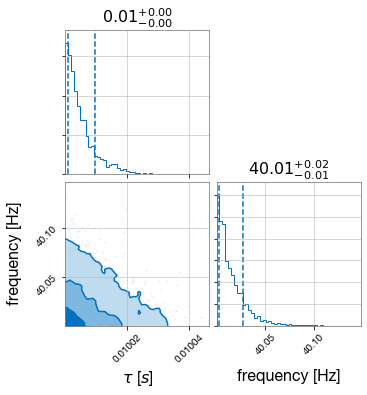

In [22]:
result.plot_corner()